In [1]:
# handling colab problem
import os
if not 'data' in os.listdir('..'):
    print('needs data folder. imports through git')
    !git clone https://github.com/JakartaLaw/speciale.git
    print(os.listdir())
    os.chdir('speciale//src')

In [2]:
from environments import EnvironmentModel1 as Environment
from environments import translate_action_model1 as translate_action
from environments import reward_scaler_model1 as reward_scaler
from environments import STATES_MU1, STATES_SIGMA1
from environments.model1 import scale_states

In [3]:
from agents import DQIterationAgent as Agent

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
class StateSpaceSampler():
    
    def __init__(self):
    
        self.Q_min = 60
        self.Q_max = 60
        
        self.K_min = 0
        self.K_max = 5
        
        self.G_min = 0.0
        self.G_max = 5.0
        
        self.Z_min = -200.0
        self.Z_max = 200.0
        
        self.beta_K_min = 0.2
        self.beta_K_max = 6.0
        
        self.beta_L_min = 0.2
        self.beta_L_max = 6.0
        
    def draw_state(self):
        Q = np.random.randint(self.Q_min, self.Q_max + 1)
        K = np.random.randint(self.K_min, self.K_max + 1)
        G = np.random.uniform(self.G_min, self.G_max)
        Z = np.random.uniform(self.Z_min, self.Z_max)
        
        beta_K = np.random.uniform(self.beta_K_min, self.beta_K_max)
        beta_L = np.random.uniform(self.beta_L_min, self.beta_L_max)
        
        return (Q, G, K, Z, beta_L)
        
    def expand_pos_states(self):
        """creates to expand possible states"""
        self.Q_min = self.Q_min - 1
        self.Q_max = self.Q_max - 1

In [14]:
def transform_state(states):
    """helper for turning states in to parameters"""
    states_ = states[0:4]
    parameters = {
        'beta_L': states[4]
    }
    return states_, parameters

In [15]:
parameters = {
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'omega': 3.5,
}

In [16]:
env = Environment(**parameters)

In [30]:
agent = Agent(0.005, 0.99 ,16, 8, 5, 4, STATES_MU1, STATES_SIGMA1)
agent.load_model("models//dqfi_model")
sss = StateSpaceSampler()
ACTIONS = np.array([0, 25, 37, 45])

In [61]:
rewards_all = list()
while sss.Q_min > 18:
    print("\n")
    print(f"age: {sss.Q_min}")
    try:
        print(f"q_scaler sigma: {float(agent.q_scaler.sigma):.2}, q_scaler mu: {float(agent.q_scaler.mu):.2}")
    except:
        pass

    for i in range(500):

        # ugly
        _states_ = sss.draw_state()
        _states, _params = transform_state(_states_)
        #scaled_state = scale_states(*_states_)


        # ugly
        rewards = np.zeros(shape=4)
        new_states = np.zeros(shape=(4, 5)) 
        for ix, action in enumerate(ACTIONS):
            env.reset(_states, _params)

            new_state, reward, done, _info = env.step(action)
            scaled_reward = reward_scaler(reward, env.beta_L)
            rewards[ix] = scaled_reward
            #rewards[ix] = reward
            new_states[ix] = new_state
        
        rewards_all.append(np.argmax(rewards))
        q_vals = agent.predict_q_vals(new_states, rewards, done)
        
        if i < 5:
            print(q_vals[0][0])
            
        agent.remember(_states_, q_vals)

    agent.learn()
    sss.expand_pos_states()



age: 60
-0.11558552919969085
0.3554924202039776
-0.04416449276855161
0.017499683421936158
0.15355522317219084
rebuilding network
# epochs: 67, loss: 0.0099, val loss: 0.00996, scaled val loss: 0.00119


age: 59
q_scaler sigma: 0.12, q_scaler mu: 0.049
0.8273914712529944
0.13049585655169932
0.18239541307465146
0.2772929842524784
-0.07955735633410418
rebuilding network
# epochs: 111, loss: 0.101, val loss: 0.116, scaled val loss: 0.0212


age: 58
q_scaler sigma: 0.18, q_scaler mu: 0.13
1.0411967190385998
0.021006272135844384
-0.06907832592401064
1.2017521611101312
1.0131173627452814
rebuilding network
# epochs: 89, loss: 0.0313, val loss: 0.0367, scaled val loss: 0.00889


age: 57
q_scaler sigma: 0.24, q_scaler mu: 0.2
1.2499539233098886
0.5016441395883101
0.19869220055062797
0.14723584412406865
0.1629447367152134
rebuilding network
# epochs: 46, loss: 0.0275, val loss: 0.0333, scaled val loss: 0.0104


age: 56
q_scaler sigma: 0.31, q_scaler mu: 0.27
0.5633154092405471
1.48070099100732

In [69]:
#agent.save_model()

{'mu': 0.3630390895127811, 'sigma': 0.39043367483622143}


In [40]:
agent.load_model("models//dqfi_model")

In [ ]:
parameters = {
    'beta_L' : 2,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'omega': 3.5,
}

env = Environment(**parameters)

EPISODES = 500

In [32]:
rewards_history, action_history = list(), list()
agent.epsilon=0.0
agent.q_scaler.mu = 0.068
agent.q_scaler.sigma = 0.16


for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        action, q_vals = agent.act(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = (reward - 24 ) / 5

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
            break

df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])

In [33]:
def random_action():
    act = np.random.randint(0, 4)
    return [0, 25, 37, 45][act]


In [34]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = random_action()
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break
            
df_random_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [35]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 0
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_0_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [36]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 37
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_37_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [37]:
rewards_history, action_history = list(), list()
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 45
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_45_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

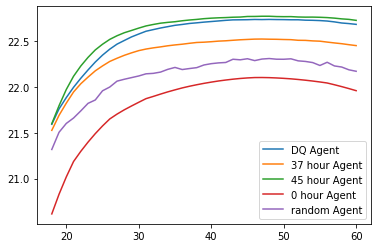

In [38]:

plt.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
plt.plot(df_37_agent.drop('episode', axis=1).groupby('Q').mean(), label='37 hour Agent')
plt.plot(df_45_agent.drop('episode', axis=1).groupby('Q').mean(), label='45 hour Agent')
plt.plot(df_0_agent.drop('episode', axis=1).groupby('Q').mean(), label='0 hour Agent')
plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='random Agent')


plt.legend()

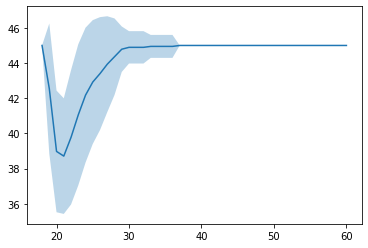

In [39]:
upper_bound = df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean() \
              + df_DQAgent_action.drop('episode', axis=1).groupby('Q').std()
lower_bound = df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean() \
              - df_DQAgent_action.drop('episode', axis=1).groupby('Q').std()

plt.plot(df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean())
plt.fill_between(range(18,61), upper_bound['actions'], lower_bound['actions'], alpha=0.3)


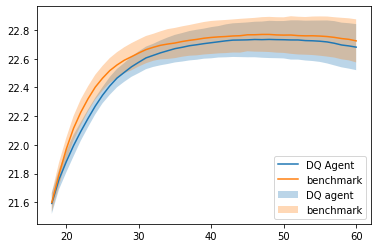

In [43]:
compare_df = df_45_agent


plt.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
upper_bound = df_DQAgent.drop('episode', axis=1).groupby('Q').mean() + df_DQAgent.drop('episode', axis=1).groupby('Q').std()
lower_bound = df_DQAgent.drop('episode', axis=1).groupby('Q').mean() - df_DQAgent.drop('episode', axis=1).groupby('Q').std()
plt.fill_between(range(18,61), upper_bound['rewards'], lower_bound["rewards"], alpha=0.3, label='DQ agent')


plt.plot(compare_df.drop('episode', axis=1).groupby('Q').mean(), label='benchmark')
upper_bound = compare_df.drop('episode', axis=1).groupby('Q').mean() + compare_df.drop('episode', axis=1).groupby('Q').std()
lower_bound = compare_df.drop('episode', axis=1).groupby('Q').mean() - compare_df.drop('episode', axis=1).groupby('Q').std()
plt.fill_between(range(18,61), upper_bound['rewards'], lower_bound["rewards"], alpha=0.3, label='benchmark')

plt.legend()